In [108]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import session_info
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
import statsmodels.api as sm

In [45]:
try:
    session_info_output = session_info.show()
except Exception as error:
    print("The session info has been requested already:")
    
session_info_output

/home/ubuntu/anaconda3/lib/python3.11/site-packages/session_info/main.py:213: DeprecationWarning: Accessing jsonschema.__version__ is deprecated and will be removed in a future release. Use importlib.metadata directly to query for jsonschema's version.
  mod_version = _find_version(mod.__version__)


In [46]:
import janitor # This library generates an error when I execute session_info()

# Import external files

- Extension of the "missing" functions from Pandas
- DataFrame and dictionary functions
- Statistical functions

In [47]:
%run utils/u.0.0-pandas_missing_extension.ipynb
%run utils/u.0.1-df_functions.ipynb
%run utils/u.0.2-statistical-functions.ipynb

# Get the processed data (V3)

In [48]:
arg_di_df = pd.read_csv('../data/processed/WDICSV_PROCESSED_V3.csv').clean_names(case_type="snake")

print(arg_di_df.shape)
arg_di_df.info()

(54, 28)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ny_gdp_mktp_kd_zg_cat   54 non-null     float64
 1   sp_dyn_le00_in_cat      54 non-null     float64
 2   it_cel_sets_cat         54 non-null     float64
 3   ny_gdp_pcap_kd_cat      54 non-null     float64
 4   se_sec_enrr_cat         54 non-null     float64
 5   ny_gdp_mktp_kd_grw_cat  54 non-null     float64
 6   year                    54 non-null     float64
 7   it_mlt_main             54 non-null     float64
 8   ny_gdp_mktp_kd_zg       54 non-null     float64
 9   ny_gdp_pcap_kd          54 non-null     float64
 10  ny_gdp_pcap_kd_zg       54 non-null     float64
 11  sp_dyn_le00_in          53 non-null     float64
 12  it_cel_sets             54 non-null     float64
 13  sh_dth_imrt             53 non-null     float64
 14  sp_pop_0014_to_zs       54 non-null

# Get columns names and types

In [49]:
indicators_names, categorical_cols, numeric_cols, columns_with_missing_values = get_columns(arg_di_df)

In [50]:
print(f'Total Columns: {len(indicators_names)}')
print(f'Categorical Columns: {len(categorical_cols)}')
print(f'Numeric Columns: {len(numeric_cols)}')

Total Columns: 28
Categorical Columns: 0
Numeric Columns: 28


In [51]:
indicators_names

['ny_gdp_mktp_kd_zg_cat, GDP growth categories',
 'sp_dyn_le00_in_cat, Life Expectancy categories',
 'it_cel_sets_cat, Mobile Subscription Categories',
 'ny_gdp_pcap_kd_cat, GDP Per Capita Categories',
 'se_sec_enrr_cat, Secondary school enrollment categories',
 'ny_gdp_mktp_kd_grw_cat, GDP Growth Volatility',
 'year, Year',
 'it_mlt_main, Fixed telephone subscriptions',
 'ny_gdp_mktp_kd_zg, GDP growth (annual %)',
 'ny_gdp_pcap_kd, GDP per capita (constant 2015 US$)',
 'ny_gdp_pcap_kd_zg, GDP per capita growth (annual %)',
 'sp_dyn_le00_in, Life expectancy at birth, total (years)',
 'it_cel_sets, Mobile cellular subscriptions',
 'sh_dth_imrt, Number of infant deaths',
 'sp_pop_0014_to_zs, Population ages 0-14 (% of total population)',
 'sp_pop_1564_to_zs, Population ages 15-64 (% of total population)',
 'sp_pop_65_up_to_zs, Population ages 65 and above (% of total population)',
 'sp_pop_totl, Population, total',
 'sm_pop_refg, Refugee population by country or territory of asylum',
 's

In [52]:
columns_with_missing_values

['se_ter_enrr',
 'sm_pop_refg_or',
 'se_pre_enrr',
 'se_prm_enrr',
 'se_sec_enrr',
 'sp_dyn_le00_in',
 'sh_dth_imrt']

# Split target variable

Target variable: sp_dyn_le00_in (Life expectancy at birth, total (years))

In [53]:
target_variable = "sp_dyn_le00_in"
target_variable_name = get_indicator_name(target_variable, True)

## Split rows with missing values

In [80]:
rows_with_na = arg_di_df[arg_di_df[target_variable].isna()].copy()
rows_with_na

,ny_gdp_mktp_kd_zg_cat,sp_dyn_le00_in_cat,it_cel_sets_cat,ny_gdp_pcap_kd_cat,se_sec_enrr_cat,ny_gdp_mktp_kd_grw_cat,year,it_mlt_main,ny_gdp_mktp_kd_zg,ny_gdp_pcap_kd,...,sm_pop_refg,sm_pop_refg_or,se_pre_enrr,se_prm_enrr,se_sec_enrr,se_ter_enrr,sp_urb_totl_in_zs,year_of_dictatorship,it_cel_sets_pct,dem_dep_cat
53,1.0,0.0,4.0,3.0,0.0,3.0,1.0,0.647369,0.432342,0.739951,...,0.041237,0.232682,NaN,NaN,NaN,NaN,1.0,0.0,0.841504,0.0


In [86]:
X = arg_di_df.dropna(subset=[target_variable]).drop(columns=target_variable)
y = arg_di_df.dropna(subset=[target_variable])[target_variable]

X.shape, y.shape

((53, 27), (53,))

# Get numerical variables

In [87]:
numeric_cols = [col for col in X.columns if not col.endswith("_cat")]
numeric_cols

['year',
 'it_mlt_main',
 'ny_gdp_mktp_kd_zg',
 'ny_gdp_pcap_kd',
 'ny_gdp_pcap_kd_zg',
 'it_cel_sets',
 'sh_dth_imrt',
 'sp_pop_0014_to_zs',
 'sp_pop_1564_to_zs',
 'sp_pop_65_up_to_zs',
 'sp_pop_totl',
 'sm_pop_refg',
 'sm_pop_refg_or',
 'se_pre_enrr',
 'se_prm_enrr',
 'se_sec_enrr',
 'se_ter_enrr',
 'sp_urb_totl_in_zs',
 'year_of_dictatorship',
 'it_cel_sets_pct']

# Impute missing values

MICE (Multiple Imputation by Chained Equations) is a technique for imputing missing data, where multiple possible values are generated for each missing entry using iterative regression models.

If dependent variables have NA values, then linear regression will predict NA results

In [89]:
mice_imputer = IterativeImputer(estimator=Ridge())

X = X[numeric_cols].copy()
X.iloc[:,:] = mice_imputer.fit_transform(X).round()


In [90]:
X.isna().sum().sum()

0

# Apply Linear Regression

## Split data

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((42, 20), (11, 20), (42,), (11,))

## Get predictions

In [92]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluate the model

In [98]:
mse = metrics.mean_squared_error(y_test, y_pred)
r2 = metrics.r2_score(y_test, y_pred)

print(round(mse,4), round(r2,2))

0.0036 0.97


In [104]:
model.coef_.reshape(-1)

array([-0.0431338 ,  0.07081431, -0.00432188, -0.0608125 , -0.00432188,
        0.01064636, -0.03424861, -0.33553629, -0.2115656 , -0.01173613,
        0.07081431, -0.03424861, -0.04406345, -0.02945742, -0.0246547 ,
        0.11816753,  0.08691555,  0.21845639, -0.07482472,  0.01064636])

In [106]:
y_pred.reshape(-1)

X_test_sm = sm.add_constant(X_test)
model_sm = sm.OLS(y_test, X_test_sm).fit()

print(model_sm.summary())

                            OLS Regression Results                            
Dep. Variable:         sp_dyn_le00_in   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     44.39
Date:                Sun, 22 Jun 2025   Prob (F-statistic):             0.0222
Time:                        17:29:55   Log-Likelihood:                 25.384
No. Observations:                  11   AIC:                            -32.77
Df Residuals:                       2   BIC:                            -29.19
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.1775 

/home/ubuntu/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


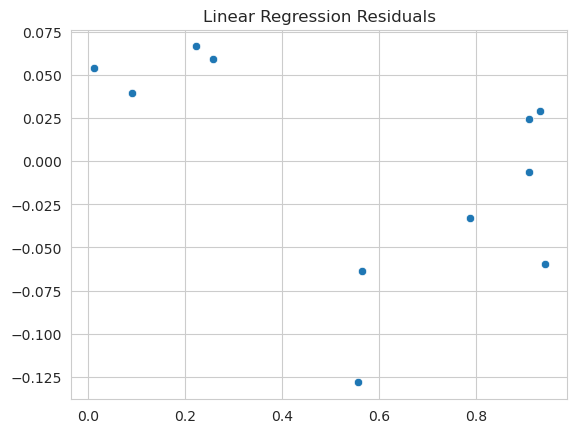

In [ ]:
residuals = np.subtract(y_test, y_pred.reshape(-1))
title = "Linear Regression Residuals"

sns.scatterplot(x=y_pred, y=residuals)
plt.title(title)
plt.ylabel("")
plt.show()